# Fit data to a Gaussian distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline  
print ("Packages loaded.")

Packages loaded.


### Define class

In [2]:
class Gaussian_class(object):
    def __init__(self,_x_dim=2,_sess=None):
        self.x_dim = _x_dim
        self.sess = _sess
        self._build_graph()
        # Initialize parameters 
        self.sess.run(tf.global_variables_initializer())
    def _build_graph(self):
        # Placeholder
        self.x = tf.placeholder(dtype=tf.float32,shape=(None,self.x_dim),name='x') # [N x x_dim]
        self.N = tf.shape(self.x)[0] # number of batch
        
        # Define mu and variance
        mu_speed = 50
        self._mu = tf.get_variable(name='mu_mtx',shape=(mu_speed,self.x_dim),
                        dtype=tf.float32,initializer=tf.constant_initializer(0.0))
        self.mu = tf.reduce_sum(self._mu,axis=0,name='mu') # [x_dim]
        logvar_speed = 50
        self._logvar = tf.get_variable(name='logvar_mtx',shape=(logvar_speed,self.x_dim),
                        dtype=tf.float32,initializer=tf.constant_initializer(0.0)) # [N x x_dim]
        self.logvar = tf.reduce_sum(self._logvar,axis=0,name='logvar') # [x_dim]
        
        # Cost function
        self.logvar_tile = tf.tile(tf.expand_dims(self.logvar,axis=0),(self.N,1)) # [N x x_dim]
        self.mu_tile = tf.tile(tf.expand_dims(self.mu,axis=0),(self.N,1)) # [N x x_dim]
        self.log_probs_mtx = -0.5*tf.log(2*np.pi) - 0.5*self.logvar_tile \
                    -0.5/tf.exp(self.logvar_tile)*tf.square(self.x-self.mu_tile) # [N x x_dim]
        self.log_probs = tf.reduce_sum(self.log_probs_mtx,axis=1) # [N]
        self.costs = -self.log_probs # [N]
        self.cost = tf.reduce_mean(self.costs) # [1]
        
        # Optimizer
        self.optm = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(self.cost)
        
        # Sampler
        self.N_sample = tf.placeholder(dtype=tf.int32,name='N_sample')
        self.eps = tf.random_normal(shape=(self.N_sample,self.x_dim),mean=0.,stddev=1.,dtype=tf.float32) # [N x x_dim]
        self.mu_sample = tf.tile(tf.expand_dims(self.mu,axis=0),(self.N_sample,1)) # [N x x_dim]
        self.logvar_sample = tf.tile(tf.expand_dims(self.logvar,axis=0),(self.N_sample,1)) # [N x x_dim]
        self.x_sample = self.mu_sample+tf.sqrt(tf.exp(self.logvar_sample))*self.eps # [N x x_dim]
        

### Train 

Gaussian_class instantiated.
[000/1000] cost:15.4193 


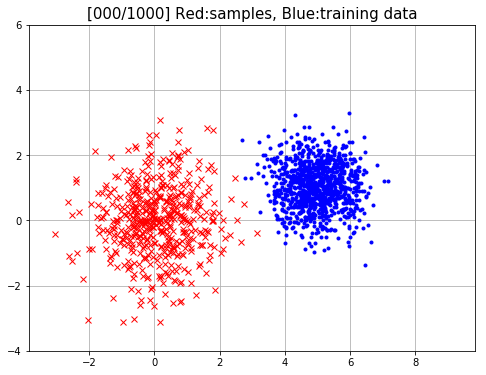

[100/1000] cost:3.3228 


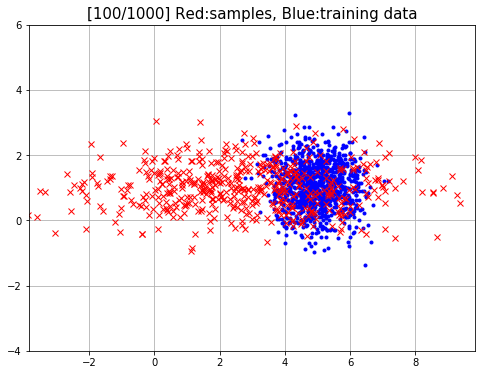

[200/1000] cost:2.9282 


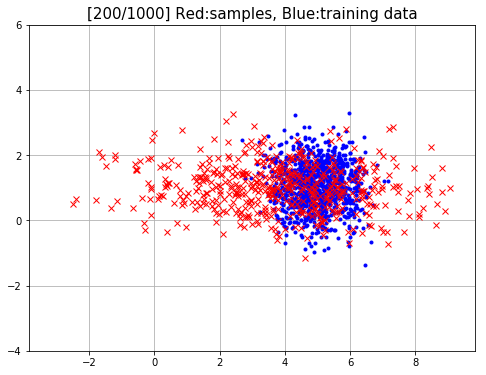

[300/1000] cost:2.4498 


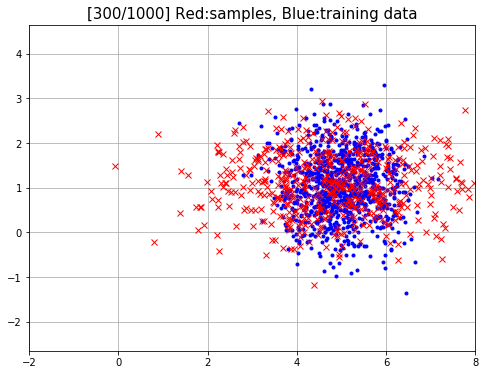

[400/1000] cost:2.1449 


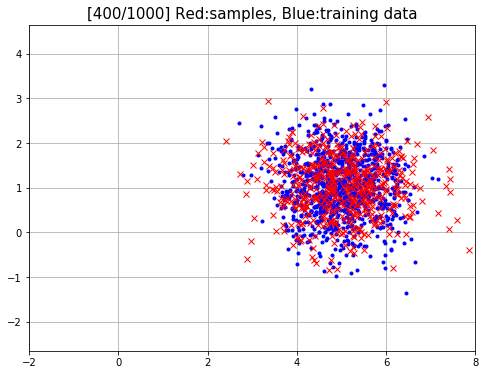

[500/1000] cost:2.2362 


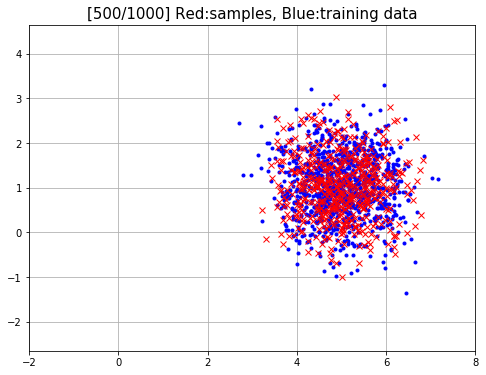

[600/1000] cost:2.1039 


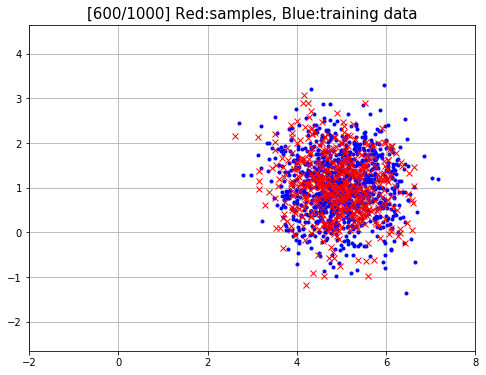

[700/1000] cost:2.1644 


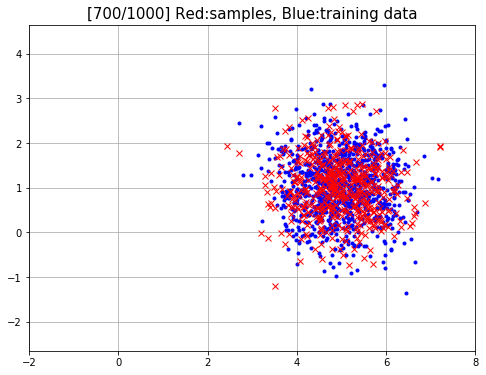

[800/1000] cost:2.2106 


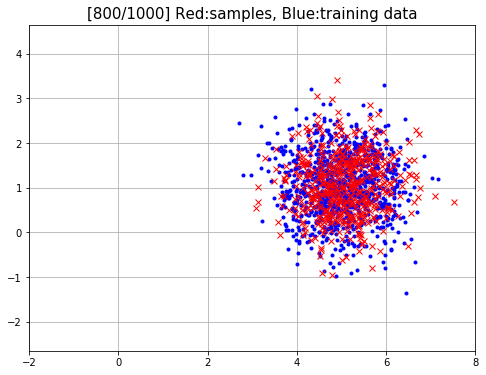

[900/1000] cost:2.0690 


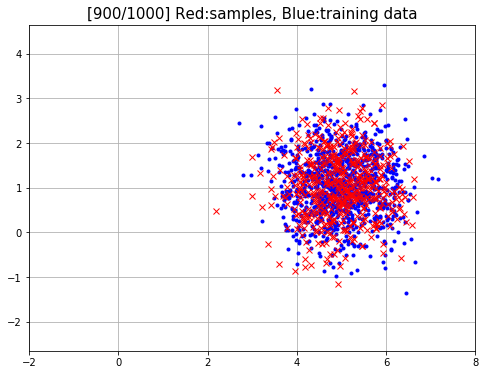

[999/1000] cost:2.2362 


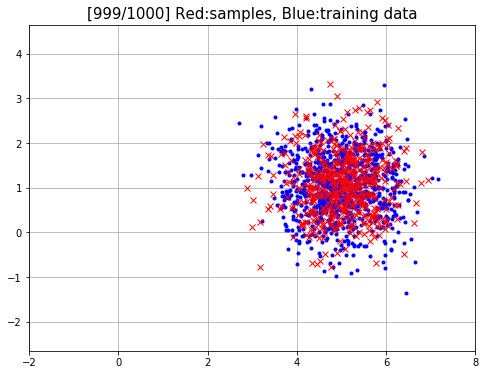

In [4]:
# Instantiate class
tf.reset_default_graph() # Reset graph
sess = tf.Session()
G = Gaussian_class(_x_dim=2,_sess=sess)
print ("Gaussian_class instantiated.")
# Training data 
N = 1000
dim = 2
X = np.array([5,1])+np.sqrt(1/2)*np.random.randn(N,dim)
# Train 
batch_size = 128
max_iter = 1000
cost_val = np.inf
for iter in range(max_iter):
    
    # Train
    x_batch = X[np.random.permutation(N)[:128],:] # current batch
    _,cost_val = G.sess.run([G.optm,G.cost],feed_dict={G.x:x_batch})
    
    # Print and plot 
    if ((iter%(max_iter//10))==0) | (iter==(max_iter-1)):
        print ("[%03d/%d] cost:%.4f "%(iter,max_iter,cost_val)) # printout cost
        # Plot
        X_sample = G.sess.run(G.x_sample,feed_dict={G.N_sample:500})
        plt.figure(figsize=(8,6));plt.plot(X[:,0],X[:,1],'b.')
        plt.plot(X_sample[:,0],X_sample[:,1],'rx')
        plt.axis('equal');plt.axis([-2,8,-4,6]);plt.grid(True)
        plt.title('[%03d/%d] Red:samples, Blue:training data'%(iter,max_iter),fontsize=15);
        plt.show()